<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw1/blob/main/NNDL_hw1_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix

from tqdm import tqdm, tqdm_notebook, notebook

from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda


Download the dataset and transform it to Tensors

In [3]:
to_tensor = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=to_tensor)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=to_tensor)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw




Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


How to get an image and the corresponding label:

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [ ]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


## NET models

In [5]:

class CnnNet(nn.Module):
    def __init__(self, net_params):

        super().__init__()

        self.net_params = net_params

        #better to fix the kernel size?
        conv1_ch = int(net_params[0])
        conv1_ker = 3
        conv2_ch = int(net_params[1])
        conv2_ker = 3
        fc1_n = int(net_params[2])
        drop_rate = net_params[3]

        # o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(drop_rate)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv1 = nn.Conv2d(1, conv1_ch, conv1_ker, padding=1)
        self.conv2 = nn.Conv2d(conv1_ch, conv2_ch, conv2_ker, padding=1)
        self.fc1 = nn.Linear(conv2_ch * 14 * 14, fc1_n)
        self.fc2 = nn.Linear(fc1_n, 10)


    def forward(self, x, additional_out=False):

        x = self.maxpool(self.dropout(self.relu(self.conv1(x))))
        x = self.dropout(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.logsoftmax(self.fc2(x))


        return x


In [6]:
class FcNet(nn.Module):
    
    def __init__(self, net_params):

        super().__init__()

        Ni, Nh1, Nh2, Nh3, No = net_params[0], net_params[1], net_params[2], net_params[3], net_params[4]


        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_rate)
        self.softmax = nn.Softmax()
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.out(x)
        return x

Training routine

## Training loop function

In [7]:

def training_loop(net, optimizer, loss_fn, 
                  train_dataloader, val_dataloader, n_epochs, verbose=False):
    train_loss_log = []
    val_loss_log = []
    val_acc_log = []
    train_acc_log = []
    for epoch_num in notebook.tqdm(range(n_epochs)):
        if verbose:
            print(f'EPOCH {epoch_num}')

        #training step
        train_loss = []
        train_acc = []
        net.train()
        for sample_batched in train_dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            # label_batch = torch.nn.functional.one_hot(label_batch)

            #forward
            out = net(x_batch)
            #compute loss
            loss = loss_fn(out, label_batch)

            #backpropagation
            net.zero_grad()
            loss.backward()

            #update weights
            optimizer.step()

            #save train loss
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

            #compute accuracy in the batch
            _, predicted = torch.max(out, 1)
            correct = (predicted == label_batch).sum().item()
            acc_batch = correct/label_batch.size(0)
            train_acc.append(acc_batch)


        #save average train loss and accuracy
        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)
        if verbose:
            print(f"train loss: {train_loss}")
            print(f"train accuracy: {train_acc}")
        train_loss_log.append(train_loss)   
        train_acc_log.append(train_acc) 

        #validation
        val_loss= []
        val_acc = []
        correct = 0
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = net(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

                #compute accuracy in the batch
                _, predicted = torch.max(out, 1)
                correct = (predicted == label_batch).sum().item()
                acc_batch = correct/label_batch.size(0)
                val_acc.append(acc_batch)
                

            # Save average validation  and accuracy
            val_acc = np.mean(val_acc)
            val_loss = np.mean(val_loss)
            if verbose:
                print(f"validation loss: {val_loss}")
                print(f"validation accuracy: {val_acc}")
            val_loss_log.append(val_loss)
            val_acc_log.append(val_acc)  

    return train_loss_log, val_loss_log, train_acc_log, val_acc_log
    #fix return in main grid search
    #add train_acc_log

# Grid search training

Choice of learning rate range is based on this article https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2

In [ ]:
batch_gs = np.array([64, 128, 256])
l2_gs = np.array([0,4e-3])
lr_gs = np.array([0.0005, 0.001,0.005])
conv1_ch_gs = np.array([8,16,32])
conv2_ch_gs = np.array([8,16,32])
fc1_gs = np.array([50,100])
drop_gs = np.array([0.1,0.2,0.3])

#maybe increase depending on how long it takes
max_size = 100

grid = product(batch_gs, l2_gs, lr_gs, conv1_ch_gs, conv2_ch_gs, fc1_gs, drop_gs)

grid_df = pd.DataFrame(list(grid))
print(len(grid_df))

if len(grid_df)>max_size:
    chosen = np.random.choice(len(grid_df), max_size, replace=False)
    chosen = np.sort(chosen)
    grid_df = grid_df.iloc[chosen,:]
    
grid_df

972


,0,1,2,3,4,5,6
7,64,0.000,0.0005,8,16,50,0.2
12,64,0.000,0.0005,8,32,50,0.1
20,64,0.000,0.0005,16,8,50,0.3
40,64,0.000,0.0005,32,8,100,0.2
41,64,0.000,0.0005,32,8,100,0.3
...,...,...,...,...,...,...,...
937,256,0.004,0.0050,16,8,50,0.2
939,256,0.004,0.0050,16,8,100,0.1
949,256,0.004,0.0050,16,32,50,0.2
958,256,0.004,0.0050,32,8,100,0.2


In [10]:
csv_name = "grid_MNIST_100ep_avg02.csv"
path_out = "/content/drive/MyDrive/UNI_ICT/NNDL/NNDL_hw1_models/"

In [ ]:
n_epochs = 30



val_search = []
#big grid search loop
for i in notebook.tqdm(range(len(grid_df))):
    # params= {'n_epochs': n_epochs, 'batch_size': grid_df.iloc[i,0], 'l2': grid_df.iloc[i,1], 'lr': grid_df.iloc[i,2] 'net_params': list(grid_df.iloc[i,3:7]) }
    # print(params)
    batch_size = grid_df.iloc[i,0]
    l2 = grid_df.iloc[i,1]
    lr = grid_df.iloc[i,2]
    net_params = list(grid_df.iloc[i,3:7])
 
    
    train_dataloader = DataLoader(train_set, batch_size=int(batch_size), shuffle=True, num_workers=0)
    val_dataloader  = DataLoader(val_set,  batch_size=len(val_set), shuffle=False, num_workers=0)

    # Initialize model
    ######fix
    # print(net_params)
    print(net_params)
    # net = CnnNet(net_params)
    net = CnnNet(net_params)
    net.to(device)  

    #unsure why this loss
    loss_fn = nn.NLLLoss()

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=l2)

    train_loss_log, val_loss_log, _, _ = training_loop(net, 
                                                 optimizer=optimizer, 
                                                 loss_fn=loss_fn, 
                                                 train_dataloader=train_dataloader, 
                                                 val_dataloader=val_dataloader, 
                                                 n_epochs=n_epochs)


    val_search.append(np.mean(val_loss_log[-1*int(np.ceil(n_epochs/10))]))


    if i%5==0:
        grid_result = grid_df.iloc[:len(val_search),:]
        grid_result['val_search'] = val_search
        grid_result.to_csv(path_out+csv_name)

grid_result = grid_df.copy()
grid_result['val_search'] = val_search





grid_result.to_csv(path_out+csv_name)

[8.0, 16.0, 50.0, 0.2]



[8.0, 32.0, 50.0, 0.1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[16.0, 8.0, 50.0, 0.3]



[32.0, 8.0, 100.0, 0.2]



[32.0, 8.0, 100.0, 0.3]



[32.0, 32.0, 100.0, 0.2]



[16.0, 32.0, 100.0, 0.2]



[16.0, 32.0, 100.0, 0.3]



[8.0, 8.0, 100.0, 0.2]



[32.0, 8.0, 100.0, 0.1]



[32.0, 32.0, 100.0, 0.1]



[8.0, 32.0, 50.0, 0.1]



[16.0, 8.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.1]



[16.0, 16.0, 50.0, 0.2]



[16.0, 16.0, 100.0, 0.1]



[16.0, 32.0, 50.0, 0.1]



[32.0, 32.0, 50.0, 0.1]



[32.0, 32.0, 100.0, 0.1]



[8.0, 8.0, 100.0, 0.2]



[8.0, 8.0, 100.0, 0.3]



[8.0, 16.0, 50.0, 0.1]



[8.0, 32.0, 100.0, 0.2]



[16.0, 8.0, 50.0, 0.2]



[8.0, 16.0, 50.0, 0.2]



[16.0, 8.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.3]



[16.0, 32.0, 50.0, 0.1]



[32.0, 16.0, 50.0, 0.2]



[32.0, 16.0, 100.0, 0.2]



[32.0, 32.0, 100.0, 0.3]



[8.0, 8.0, 100.0, 0.2]



[8.0, 8.0, 100.0, 0.3]



[8.0, 32.0, 100.0, 0.1]



[16.0, 8.0, 50.0, 0.2]



[16.0, 8.0, 100.0, 0.1]



[16.0, 16.0, 50.0, 0.1]



[32.0, 8.0, 100.0, 0.1]



[8.0, 16.0, 50.0, 0.2]



[16.0, 16.0, 100.0, 0.2]



[16.0, 32.0, 100.0, 0.2]



[32.0, 32.0, 100.0, 0.1]



[16.0, 8.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.1]



[16.0, 16.0, 50.0, 0.2]



[32.0, 32.0, 100.0, 0.2]



[16.0, 8.0, 100.0, 0.1]



[16.0, 16.0, 100.0, 0.1]



[32.0, 16.0, 50.0, 0.3]



[8.0, 8.0, 100.0, 0.2]



[16.0, 8.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.2]



[16.0, 16.0, 50.0, 0.3]



[32.0, 8.0, 100.0, 0.2]



[32.0, 16.0, 50.0, 0.1]



[32.0, 16.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.3]



[16.0, 16.0, 100.0, 0.1]



[16.0, 16.0, 100.0, 0.3]



[16.0, 32.0, 100.0, 0.3]



[32.0, 8.0, 100.0, 0.3]



[8.0, 8.0, 50.0, 0.3]



[8.0, 8.0, 100.0, 0.3]



[8.0, 16.0, 100.0, 0.3]



[16.0, 8.0, 50.0, 0.2]



[16.0, 16.0, 50.0, 0.3]



[16.0, 16.0, 100.0, 0.2]



[16.0, 32.0, 50.0, 0.1]



[8.0, 32.0, 50.0, 0.2]



[8.0, 32.0, 100.0, 0.3]



[16.0, 8.0, 100.0, 0.1]



[32.0, 8.0, 50.0, 0.2]



[32.0, 16.0, 50.0, 0.2]



[32.0, 16.0, 50.0, 0.3]



[32.0, 32.0, 100.0, 0.1]



[8.0, 8.0, 50.0, 0.2]



[8.0, 8.0, 100.0, 0.1]



[16.0, 16.0, 100.0, 0.2]



[16.0, 32.0, 50.0, 0.3]



[32.0, 8.0, 100.0, 0.1]



[32.0, 16.0, 50.0, 0.1]



[8.0, 8.0, 100.0, 0.2]



[8.0, 32.0, 100.0, 0.2]



[16.0, 8.0, 100.0, 0.2]



[16.0, 16.0, 50.0, 0.1]



[16.0, 16.0, 100.0, 0.1]



[16.0, 32.0, 100.0, 0.3]



[32.0, 32.0, 50.0, 0.2]



[8.0, 32.0, 100.0, 0.1]



[16.0, 8.0, 100.0, 0.3]



[16.0, 32.0, 100.0, 0.2]



[32.0, 8.0, 100.0, 0.1]



[32.0, 16.0, 100.0, 0.3]



[32.0, 32.0, 100.0, 0.3]



[8.0, 8.0, 50.0, 0.3]



[16.0, 8.0, 50.0, 0.2]



[16.0, 8.0, 100.0, 0.1]



[16.0, 32.0, 50.0, 0.2]



[32.0, 8.0, 100.0, 0.2]



[32.0, 16.0, 100.0, 0.1]


# Anlaysis of the grid search results

In [11]:
grid_result = pd.read_csv(path_out+csv_name, usecols=[str(x) for x in range(7)]+[ 'val_search'])

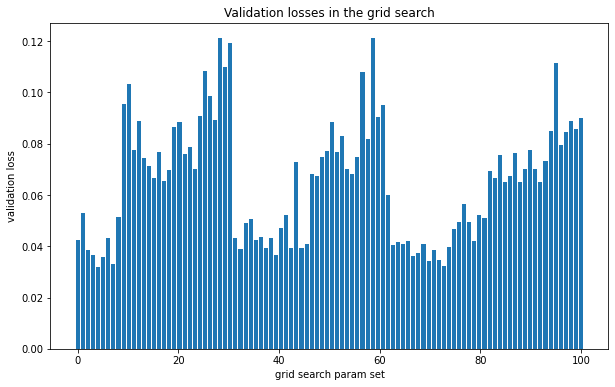

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

# ax.grid_result['val_kfold_avg'].plot()
ax.bar(np.linspace(0,len(grid_result), len(grid_result)), grid_result['val_search'])
ax.set_title('Validation losses in the grid search')
ax.set_xlabel('grid search param set')
ax.set_ylabel('validation loss')
fig.show()


In [15]:
#sort to have the better performance at first
grid_result = grid_result.sort_values(by='val_search', )
grid_result

,0,1,2,3,4,5,6,val_search
4,64,0.000,0.0005,32,8,100,0.3,0.031778
72,256,0.000,0.0010,32,16,50,0.2,0.032298
7,64,0.000,0.0010,16,32,100,0.3,0.032906
69,256,0.000,0.0010,8,32,100,0.3,0.034245
71,256,0.000,0.0010,32,8,50,0.2,0.034791
...,...,...,...,...,...,...,...,...
29,64,0.004,0.0050,32,16,100,0.2,0.109782
94,256,0.004,0.0050,8,8,50,0.3,0.111496
30,64,0.004,0.0050,32,32,100,0.3,0.119210
58,128,0.004,0.0050,16,16,100,0.3,0.121058


In [17]:
best_params = list(grid_result.iloc[0,:-1]) 
best_params

[64.0, 0.0, 0.0005, 32.0, 8.0, 100.0, 0.3]

## Retrain the best parameters model

In [18]:
batch_size = best_params[0]
l2 = best_params[1]
lr = best_params[2]
net_params = list(best_params[3:7])
n_epochs = 50

full_train_dataloader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

# Initialize model
######fix
# print(net_params)
print(net_params)
# net = CnnNet(net_params)
net = CnnNet(net_params)
net.to(device)  

#unsure why this loss
loss_fn = nn.NLLLoss()

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=l2)

train_loss_log, test_loss_log, train_acc, test_acc = training_loop(net, 
                                                optimizer=optimizer, 
                                                loss_fn=loss_fn, 
                                                train_dataloader=full_train_dataloader, 
                                                val_dataloader=test_dataloader, 
                                                n_epochs=n_epochs,
                                                verbose=True)

[32.0, 8.0, 100.0, 0.3]


EPOCH 0
train loss: 0.3907502591609955
train accuracy: 0.8799473614072495
validation loss: 0.13219575583934784
validation accuracy: 0.965
EPOCH 1
train loss: 0.1521192342042923
train accuracy: 0.9535414445628998
validation loss: 0.08455493301153183
validation accuracy: 0.9773
EPOCH 2
train loss: 0.11384215205907822
train accuracy: 0.9657182835820896
validation loss: 0.06343518942594528
validation accuracy: 0.9816
EPOCH 3
train loss: 0.09502343833446503
train accuracy: 0.9710654317697228
validation loss: 0.053686805069446564
validation accuracy: 0.9852
EPOCH 4
train loss: 0.08401501923799515
train accuracy: 0.9745302505330491
validation loss: 0.04953613504767418
validation accuracy: 0.9854
EPOCH 5
train loss: 0.07490315288305283
train accuracy: 0.976629131130064
validation loss: 0.04469987750053406
validation accuracy: 0.9868
EPOCH 6
train loss: 0.06904759258031845
train accuracy: 0.9782116204690832
validation loss: 0.04395592585206032
validation accuracy: 0.9864
EPOCH 7
train loss: 0.0

Visualize the Accuracy and Loss plots with the training set

Final training accuracy: 0.9928
Final training loss: 0.024558743461966515


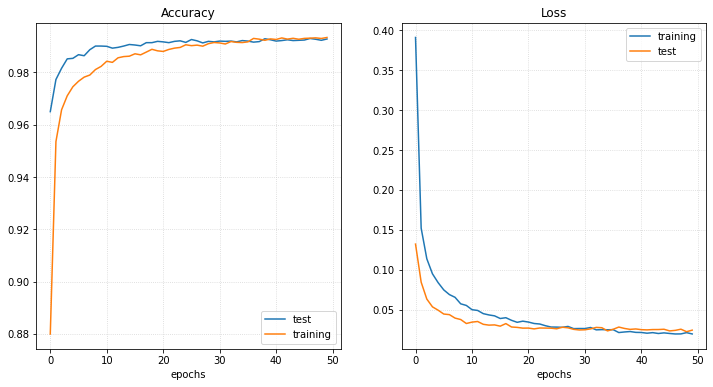

In [119]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title("Accuracy")
ax2.set_title("Loss")
# ax.semilogy(train_loss_log, label="training")
ax1.plot(test_acc, label="test")
ax1.plot(train_acc, label='training')
ax2.plot(train_loss_log, label='training')
ax2.plot(test_loss_log, label='test')
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')

ax1.set_xlabel("epochs")

ax2.set_xlabel("epochs")

ax1.legend()
ax2.legend()

fig.show()

print(f'Final training accuracy: {test_acc[-1]}')
print(f'Final training loss: {test_loss_log[-1]}')

## save and load best network

Skip the final training loading the model

In [24]:
path_out = "/content/drive/MyDrive/UNI_ICT/NNDL/NNDL_hw1_models/"
model_name = "best_cnn01.torch"

In [25]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
# Save the state dict to a file
torch.save(net_state_dict, path_out+model_name)

In [ ]:
### Reload the network state
# First initialize the network (if not already done)
net = Net(net_params) 
# Load the state dict previously saved
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)

## prediction for the classes on the test set 

Inference on the test set

In [26]:
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)


all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels ina single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)


Get predicted classes

In [27]:
predicted_label = torch.argmax(all_outputs, 1)
predicted_label = predicted_label.cpu().numpy()
test_label = all_labels.cpu().numpy()



# Visualization of results and features

## confusion matrix

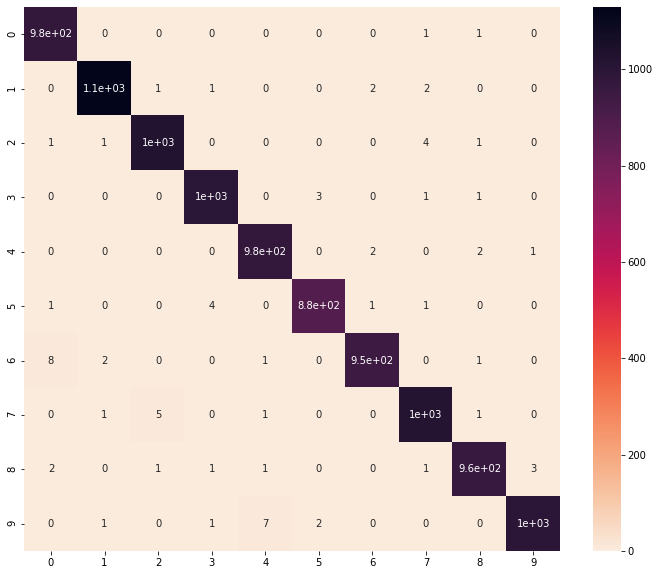

In [28]:
cm_array = confusion_matrix(test_label, predicted_label, normalize=None)
# print(cm_array)
cm = pd.DataFrame(cm_array,index=range(10), columns=range(10))

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, cmap="rocket_r")

plt.show()

Fron the confusion matrix we can see there are very few wrongly classified samples

retrieve layers

In [113]:
# First conv layer
conv1_w = net.conv1.weight.data.cpu().numpy()
conv1_b = net.conv1.bias.data.cpu().numpy()

# Second conv layer
conv2_w = net.conv2.weight.data.cpu().numpy()
conv2_b = net.conv2.bias.data.cpu().numpy()

# First fc layer
fc1_w = net.fc1.weight.data.cpu().numpy()
fc1_b = net.fc1.bias.data.cpu().numpy()

# second fc layer
fc2_w = net.fc1.weight.data.cpu().numpy()
fc2_b = net.fc1.bias.data.cpu().numpy()


## weights histogram

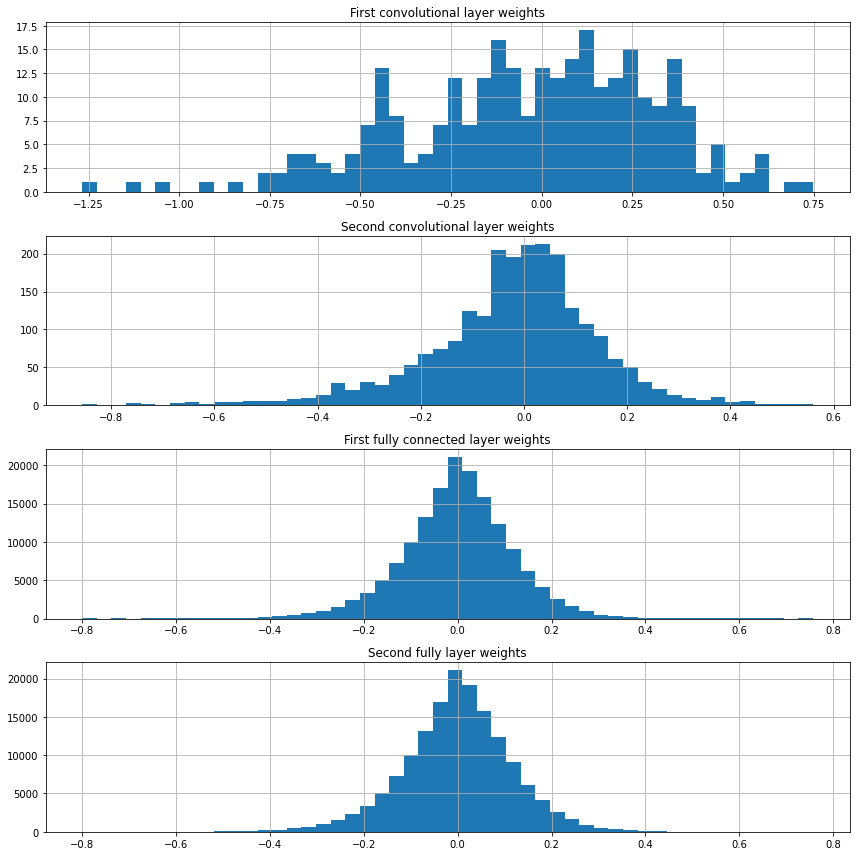

In [116]:
fig, axs = plt.subplots(4, 1, figsize=(12,12))
axs[0].hist(conv1_w.flatten(), 50)
axs[0].set_title('First convolutional layer weights')
axs[1].hist(conv2_w.flatten(), 50)
axs[1].set_title('Second convolutional layer weights')
axs[2].hist(fc1_w.flatten(), 50)
axs[2].set_title('First fully connected layer weights')
axs[3].hist(fc2_w.flatten(), 50)
axs[3].set_title('Second fully layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## Kernels visualization

torch.Size([32, 1, 3, 3])


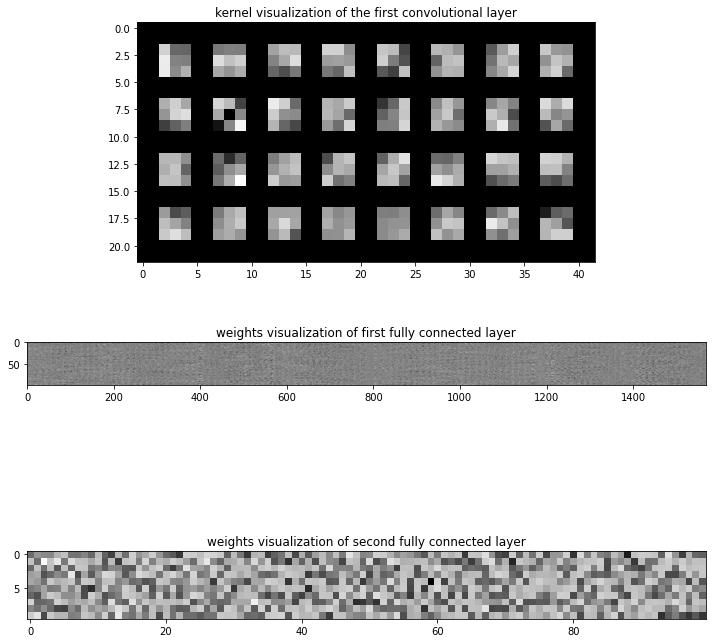

In [110]:
import torchvision
net.to(torch.device('cpu'))

def normalize01(x):
    y = x-x.min()
    y = y/y.max()
    return y 

conv1 = normalize01(net.conv1.weight.detach().clone())
conv2 = normalize01(net.conv2.weight.detach().clone())
fc1 = normalize01(net.fc1.weight.detach().clone())
fc2 = normalize01(net.fc2.weight.detach().clone())


fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].imshow(torchvision.utils.make_grid(conv1, nrow=8).permute(1,2,0))
ax[0].set_title("kernel visualization of the first convolutional layer")
ax[1].imshow(torchvision.utils.make_grid(fc1, nrow=8).permute(1,2,0,))
ax[1].set_title("weights visualization of first fully connected layer")
ax[2].imshow(torchvision.utils.make_grid(fc2, nrow=8).permute(1,2,0,))
ax[2].set_title("weights visualization of second fully connected layer")
plt.tight_layout()
